In [ ]:
from torch_geometric.nn import MessagePassing
from torch_scatter import scatter_mean
import pandas as pd


#this is the main model you will be working with 
class TrustGNN(MessagePassing):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__(aggr='mean')

        self.lin_self = torch.nn.Linear(in_channels, hidden_channels)
        self.lin_neigh = torch.nn.Linear(in_channels, hidden_channels)

        # the example solution is here : learn how much to trust self vs neighbors
        self.trust_gate = torch.nn.Sequential(
            torch.nn.Linear(2 * hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, 1),
            torch.nn.Sigmoid()
        )

        self.classifier = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h_self = self.lin_self(x)
        h_neigh = self.propagate(edge_index, x=x)

        gate = self.trust_gate(torch.cat([h_self, h_neigh], dim=1))
        h = gate * h_self + (1 - gate) * h_neigh

        return self.classifier(h)

    def message(self, x_j):
        return self.lin_neigh(x_j)


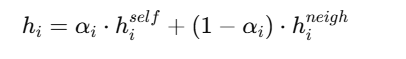


In [ ]:
#we train the model now using this aggregation function
train_df = pd.read_csv("/kaggle/input/data/train.csv")

x = torch.tensor(
    train_df.filter(like="feature_").values,
    dtype=torch.float
)

y = torch.tensor(train_df["label"].values)


In [ ]:
valid_nodes = set(range(x.shape[0]))  
edge_df = edge_df[edge_df['source'].isin(valid_nodes) & edge_df['target'].isin(valid_nodes)]

edge_index = torch.tensor(edge_df[["source", "target"]].values.T, dtype=torch.long)


In [30]:
model = TrustGNN(
    in_channels=x.shape[1],
    hidden_channels=64,
    out_channels=7
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    logits = model(x, edge_index)
    loss = loss_fn(logits, y)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.9496
Epoch 20, Loss: 0.3802
Epoch 40, Loss: 0.1909
Epoch 60, Loss: 0.1626
Epoch 80, Loss: 0.1438
Epoch 100, Loss: 0.1160
Epoch 120, Loss: 0.0874
Epoch 140, Loss: 0.0595
Epoch 160, Loss: 0.0399
Epoch 180, Loss: 0.0312


In [ ]:
valid_test_nodes = set(range(x_test.shape[0])) 
edge_test_df = edge_df[edge_df['source'].isin(valid_test_nodes) & edge_df['target'].isin(valid_test_nodes)]

edge_index_test = torch.tensor(edge_test_df[['source','target']].values.T, dtype=torch.long)


In [ ]:
#The testing section! Moment of the truth ! 
#Remember to use the required metrics : 
#   Accuracy
#   F1-Score
#   Precision & Recall
#   
test_df = pd.read_csv("/kaggle/input/data/test.csv")

x_test = torch.tensor(
    test_df.filter(like="feature_").values,
    dtype=torch.float
)

model.eval()
with torch.no_grad():
    #......
